### <font color ='red'>Importação de Libs </font>

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
tfds.disable_progress_bar()

### <font color = 'red'> Importação do Dataset </font>

In [4]:
builder = tfds.builder('rock_paper_scissors')
info = builder.info

info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path='/root/tensorflow_datasets/rock_paper_scissors/3.0.0',
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)

### <font color='red' > Preparação dos dados </font>

In [5]:
dataset_train = tfds.load(name="rock_paper_scissors", split="train")
dataset_test = tfds.load(name="rock_paper_scissors", split="test")

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


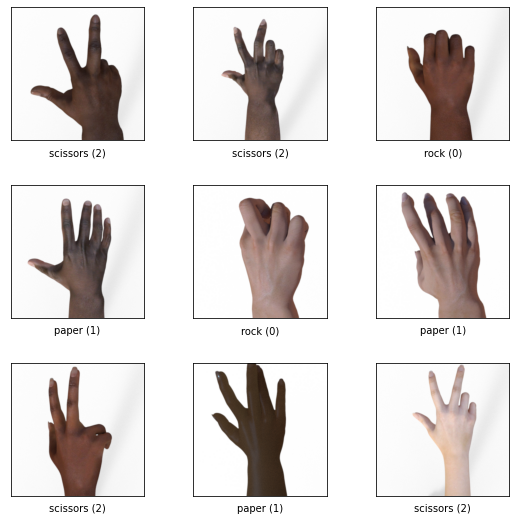

In [6]:
fig = tfds.show_examples(info, dataset_train)

In [7]:
# https://www.tensorflow.org/datasets/overview#as_dict
train_images = np.array([example['image'].numpy()[:,:,0] for example in dataset_train])
train_labels = np.array([example['label'].numpy() for example in dataset_train])

test_images = np.array([example['image'].numpy()[:,:,0] for example in dataset_test])
test_labels = np.array([example['label'].numpy() for example in dataset_test])

In [8]:
train_images = train_images.reshape(2520, 300, 300, 1)
test_images = test_images.reshape(372, 300, 300, 1)

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images /= 255
test_images /= 255

### <font color = 'red'> Treinando a Rede Neural </font>

In [ ]:
model1 = keras.Sequential([
  keras.layers.Flatten(),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(3, activation='softmax')
])

model1.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model1.fit(train_images, train_labels, epochs=5, batch_size=32)

In [20]:
model1.evaluate(test_images, test_labels)

12/12 [==============================] - 1s 31ms/step - loss: 2.0062 - accuracy: 0.4785


[2.0062005519866943, 0.4784946143627167]

## <font color = 'red'> Treinando Rede Neural (Convolucional) <font>

In [ ]:
model2 = keras.Sequential([
   keras.layers.AveragePooling2D(6,3, input_shape=(300,300,1)),
   keras.layers.Conv2D(64, 3, activation='relu'),
   keras.layers.Conv2D(32, 3, activation='relu'),
   keras.layers.MaxPool2D(2,2),
   keras.layers.Dropout(0.5),
   keras.layers.Flatten(),
   keras.layers.Dense(128, activation='relu'),
   keras.layers.Dense(3, activation='softmax')
])

model2.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model2.fit(train_images, train_labels, epochs=5, batch_size=32)

In [22]:
model2.evaluate(test_images,test_labels)

12/12 [==============================] - 1s 63ms/step - loss: 1.0595 - accuracy: 0.6882


[1.0595241785049438, 0.6881720423698425]

## <font color='red'> Treinando com Hyperparâmetros  </font>

In [26]:
#pip install -U keras-tuner

In [30]:
from kerastuner.tuners import RandomSearch

def build_model(hp):
  model = keras.Sequential()

  model.add(keras.layers.AveragePooling2D(6,3,input_shape=(300,300,1)))

  for i in range(hp.Int("Conv Layers", min_value=0, max_value=3)):
    model.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters", [16,32,64]), 3, activation='relu'))
  
  model.add(keras.layers.MaxPool2D(2,2))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(hp.Choice("Dense layer", [64, 128, 256, 512, 1024]), activation='relu'))

  model.add(keras.layers.Dense(3, activation='softmax'))

  model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  
  return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=16,
)

tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=16)

Trial 16 Complete [00h 12m 12s]
val_accuracy: 0.7096773982048035

Best val_accuracy So Far: 0.7983871102333069
Total elapsed time: 00h 36m 32s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [31]:
best_model = tuner.get_best_models()[0]

In [32]:
best_model.evaluate(test_images, test_labels)

12/12 [==============================] - 1s 45ms/step - loss: 0.6316 - accuracy: 0.7984


[0.6316186785697937, 0.7983871102333069]

In [33]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d (AverageP  (None, 99, 99, 1)        0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 97, 97, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 95, 95, 16)        9232      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 16)        0         
                                                                 
 flatten (Flatten)           (None, 35344)             0

In [34]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
Conv Layers: 2
Dense layer: 64
layer_0_filters: 64
layer_1_filters: 16
layer_2_filters: 32
Score: 0.7983871102333069

Trial 04 summary
Hyperparameters:
Conv Layers: 1
Dense layer: 256
layer_0_filters: 16
layer_1_filters: 32
layer_2_filters: 64
Score: 0.7876344323158264

Trial 10 summary
Hyperparameters:
Conv Layers: 2
Dense layer: 64
layer_0_filters: 64
layer_1_filters: 32
layer_2_filters: 64
Score: 0.7768816947937012

Trial 12 summary
Hyperparameters:
Conv Layers: 3
Dense layer: 64
layer_0_filters: 64
layer_1_filters: 32
layer_2_filters: 64
Score: 0.7688171863555908

Trial 14 summary
Hyperparameters:
Conv Layers: 3
Dense layer: 128
layer_0_filters: 16
layer_1_filters: 64
layer_2_filters: 32
Score: 0.7526881694793701

Trial 03 summary
Hyperparameters:
Conv Layers: 3
Dense layer: 128
layer_0_filters: 64
layer_1_filters: 16
layer_2_filter

### <font color = 'red'>  Salvando o modelo </font>

In [35]:
best_model.save('./my_model')

INFO:tensorflow:Assets written to: ./my_model/assets


INFO:tensorflow:Assets written to: ./my_model/assets


In [36]:
loaded_model = keras.models.load_model('./my_model')

In [37]:
loaded_model.evaluate(test_images, test_labels)

12/12 [==============================] - 1s 50ms/step - loss: 0.6316 - accuracy: 0.7984


[0.6316186785697937, 0.7983871102333069]

## <font color='red'> Criando bucket </font>

In [41]:
import boto3
from botocore.exceptions import ClientError
from sagemaker.s3 import S3Uploader
import io
import pickle
session = boto3.Session()
bucket = 'compass-sprint5-grupo2'

session.client('s3').create_bucket(Bucket = bucket)

{'ResponseMetadata': {'RequestId': 'SR6AVEY66XXCG2G6',
  'HostId': 'Zr3TfqQka5YCGjClNx0g15ZxSuaNJKxc7xtpGXom1SfNIUfwkZ0LNJLacBK8EhyVFzjh/7Dfm1c=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Zr3TfqQka5YCGjClNx0g15ZxSuaNJKxc7xtpGXom1SfNIUfwkZ0LNJLacBK8EhyVFzjh/7Dfm1c=',
   'x-amz-request-id': 'SR6AVEY66XXCG2G6',
   'date': 'Mon, 17 Apr 2023 14:11:18 GMT',
   'location': '/compass-sprint5-grupo2',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'Location': '/compass-sprint5-grupo2'}

In [49]:
## Configurando o caminho:
bucket = 'compass-sprint5-grupo2'
subpasta_train = 'datasets/rps/train/'
subpasta_test = 'datasets/rps/test/'
subpasta_model = 'modelos/'

In [46]:
## Implementa protocolos binários para serializar e desserializar uma estrutura de objeto Python:
train_images_data = io.BytesIO()
train_labels_data = io.BytesIO()
test_images_data = io.BytesIO()
test_labels_data = io.BytesIO()

pickle.dump(train_images, train_images_data)
pickle.dump(train_labels, train_labels_data)

pickle.dump(test_images, test_images_data)
pickle.dump(test_labels, test_labels_data)

train_images_data.seek(0)
train_labels_data.seek(0)
test_images_data.seek(0)
test_labels_data.seek(0)


## Upload dos Arquivos

s3_client = boto3.client('s3')

s3_client.upload_fileobj(train_images_data, bucket, subpasta_train+ 'train_images.pkl')
s3_client.upload_fileobj(train_labels_data, bucket, subpasta_train+ 'train_labels.pkl')

s3_client.upload_fileobj(test_images_data, bucket, subpasta_test + 'test_images.pkl')
s3_client.upload_fileobj(test_labels_data, bucket, subpasta_test + 'test_labels.pkl')

## <font color='red'> Prevendo Resultado </font>

In [84]:
result = best_model.predict(np.array([train_images[3]]))
print(result)

predicted_value = np.argmax(result)
print(predicted_value)

1/1 [==============================] - 0s 31ms/step
[[0.00455876 0.99353564 0.0019057 ]]
1


## <font color='red'> Observações </font>

<p> Para execução do script no Sagemaker foi utilizado  o setup  TensorFlow 2.10.0 Python 3.9 CPU Optimized  - Instance Type = ml.t3.xlarge</p>

<p> URL Bucket = https://compass-sprint5-grupo2.s3.amazonaws.com/datasets/<p>